### **This notebook checks who are the targets in replying**
**RQ1: Manually check who are they replying to (both verified and not verified accounts.)**

In [3]:
import pandas as pd
import numpy as np
import datetime
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
import sys
import os

import importlib

#### packages
import helper.strategy_helper as st
import helper.visualization as vz
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config_hp
import helper.pandas_helper as pd_hp

##### **Loading config files**

In [4]:
config = config_hp.config()
path = config['PATHS']
poster_path = config['POSTER_PATH']

poster_alive_file = poster_path['poster_alive_file']

##### **Read reply files**

In [4]:
df_replies = pd.read_pickle(external_reply)

In [5]:
df_replies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21427154 entries, 0 to 21427153
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   replier_tweetid  int64  
 1   replier_userid   object 
 2   poster_tweetid   float64
 3   poster_userid    float64
 4   tweet_language   object 
 5   tweet_time       object 
 6   year             object 
 7   campaign         object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.3+ GB


##### **Grouping by the poster tweetid, year, campaign**

In [12]:
df_replies = df_replies.drop_duplicates()

df_count = (df_replies.groupby(['poster_tweetid', 
                                'year',
                                'campaign'
                               ])['replier_userid']
             .nunique()
             .to_frame('replier_count')
             .reset_index()
            )
df_count_5 = df_count.loc[df_count['replier_count'] >= 5]

print('Total tweets with 5 or more replies: ',
      len(df_count_5))

Total tweets with 5 or more replies:  94630


##### **Grouping just by the poster tweetid**

In [11]:
df_count_twt = (df_replies.groupby(['poster_tweetid'])['replier_userid']
             .nunique()
             .to_frame('replier_count')
             .reset_index()
            )

df_5 = df_count_twt.loc[df_count_twt['replier_count'] >= 5]

print('Total tweets with 5 or more replies: ',
      len(df_5))

Total tweets with 5 or more replies:  96041


There is discrepency in number of tweets when grouping by just poster tweetids and adding campaign and year.

In [53]:
df_common_twt = (df_replies.groupby(['poster_tweetid'])['campaign']
                 .nunique()
                 .to_frame('campaign_count')
                 .reset_index()
                )

print('Max count : ', df_common_twt['campaign_count'].max())

Max count :  7


In [26]:
df_common_twt = df_common_twt.astype({
    'poster_tweetid': int,
})

In [27]:
df_common_twt.loc[df_common_twt['campaign_count'] == df_common_twt['campaign_count'].max()]

,poster_tweetid,campaign_count
10568076,1021234525626609664,7


In [33]:
df_replies = df_replies.astype({
    'poster_tweetid': int,
    'poster_userid': int
})

df_count = df_count.astype({
    'poster_tweetid': int,
    # 'poster_userid': int
})

In [34]:
df_count.loc[df_count['poster_tweetid'] == 1021234525626609664]

,poster_tweetid,year,campaign,replier_count
10600328,1021234525626609664,2018_10,iranian,6
10600329,1021234525626609664,2019_01,iran_201901_1,8
10600330,1021234525626609664,2019_01,russia_201901_1,1
10600331,1021234525626609664,2019_06,iran_201906,7
10600332,1021234525626609664,2019_11,saudi_arabia_112019,1
10600333,1021234525626609664,2020_04,sa_eg_ae_022020,1
10600334,1021234525626609664,2020_12,iran_202012,2


##### **Tweets common accross the campaigns**

In [37]:
df_common_twt.loc[df_common_twt['campaign_count'] >=2]['campaign_count'].unique()

array([2, 3, 4, 6, 5, 7])

/tmp/ipykernel_726856/2404418315.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


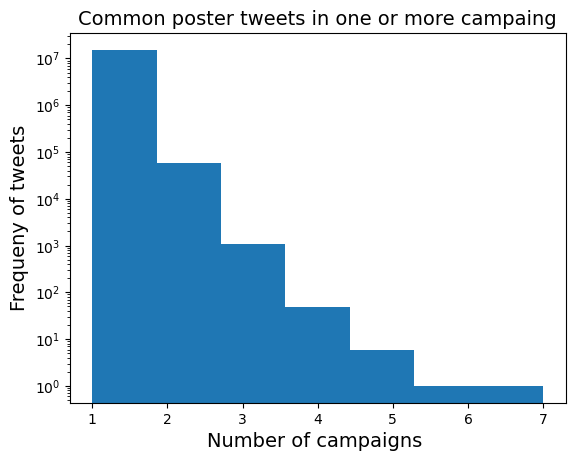

In [42]:
import imp

imp.reload(vz)

parameters =  {
    'data': df_common_twt,
    'fontsize': 14,
    'columns': [
        {'column': 'campaign_count',
         'label': 'Count of Replies',
        }
    ],
    'xlabel': 'Number of campaigns ',
    'ylabel': 'Frequeny of tweets',
    'legend_location': '',
    'log_yscale': True,
    'log_xscale': False,
    'bins': None,
    'save': {
        'path': path['plot_path'],
        'filename': 'common_tweets_in_campaing.png'
    },
    'title': 'Common poster tweets in one or more campaign'
}

vz.plot_histogram(parameters)

**What could be the case:** <br />
Two or more campaign going on in the same time. <br />
Targeting the same person. <br />

##### **Jaccard coefficient: Which campaigns have highest common tweets**

In [54]:
df_common_twt = df_common_twt.drop_duplicates()

df_common_twt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15256547 entries, 0 to 15256546
Data columns (total 2 columns):
 #   Column          Dtype
---  ------          -----
 0   poster_tweetid  int64
 1   campaign_count  int64
dtypes: int64(2)
memory usage: 349.2 MB


In [55]:
df_common_twt_2 = df_common_twt.loc[df_common_twt['campaign_count'] >= 2]

In [56]:
df_count_camp = df_count.loc[
    df_count['poster_tweetid'].isin(df_common_twt_2['poster_tweetid'])]

In [57]:
df_count_camp.head()

,poster_tweetid,year,campaign,replier_count
17891,5432223636,2019_01,venezuela_201901,2
17892,5432223636,2019_08,ecuador_082019,1
70670,16983799828,2019_01,venezuela_201901,1
70671,16983799828,2019_08,ecuador_082019,1
93557,21461138919,2019_01,venezuela_201901,1


In [60]:
df_tweet_list = (df_count_camp
    .groupby(['campaign', 'year'])['poster_tweetid']
    .apply(lambda x: set(np.unique(x)))
    .to_frame('tweet_list')
    .reset_index())

In [70]:
df_tweet_list['tweet_count'] = df_tweet_list['tweet_list'].apply(
    lambda x: len(x)
)

In [71]:
print('Max tweets are from this campaign :')

df_tweet_list.loc[
    df_tweet_list['tweet_count'] == df_tweet_list['tweet_count'].max()]

Max tweets are from this campaign :


,campaign,year,tweet_list,jaccard,tweet_count
27,sa_eg_ae_022020,2020_04,"{171460960001851392, 463034024269971456, 68695...",0.457702,26603


In [95]:
jaccard_for_campaign = []
for index, row in df_tweet_list.iterrows():
    temp = {}
    temp['campaing'] = row['campaign']
    temp['year'] = row['year']
    temp['jaccard'] = {}
    
    for index_next, row_next in df_tweet_list.iterrows():
        if index == index_next:
            continue
        all_in = len(row['tweet_list'].union(row_next['tweet_list']))
        intersect = len(list(row['tweet_list'] & row_next['tweet_list']))
        temp['jaccard'][row_next['campaign']] = round(intersect/all_in, 4)
        
    jaccard_for_campaign.append(temp)

In [99]:
# jaccard_for_campaign

##### **Note on the targets:**
|Job| USERID      | Description |
|----| ----------- | ----------- |
| 1 | Header      | Title       |
|   | Paragraph   | Text        |

In [109]:
poster_path = path['poster_path']
print('poster path :', poster_path)
print('splitted conversation ids :', splited_reply_ids)

poster path : /N/slate/potem/data/derived/posters
splitted conversation ids : /N/slate/potem/data/derived/conversation/5_reply_count


In [114]:
poster_info_path = file_hp.create_folder(derived_path, 
                                          'posters_info')

In [116]:
poster_info = os.path.join(poster_info_path, 'poster_info.txt')

In [155]:
all_posters = []
isExist = os.path.exists(poster_info)
if isExist == True:
    with open(f'{poster_info}', 'r') as fp:
        lines = fp.readlines()
        for line in lines:
            x = line.replace("\n", "").strip('][').split(', ')

            #x - job_id,poster_userid,info
            all_posters.append(int(x[1]))


ids = [i for i in range(1, 62)]
index = 0
for i in ids:
    filename = f'posters_job_{i}_{index}_{index+50}.txt'
    conv_file = f'job_{i}_{index}_{index+50}.txt'
    index = index + 50
    poster_id_path = os.path.join(poster_path, filename)
    # conversation_id_path = os.path.join(splited_reply_ids, conv_file)
    
    posters = list(set(file_hp.read_file(poster_id_path)))
    # conv_ids = file_hp.read_file(conversation_id_path)
    with open(poster_info, 'a+') as f:
        for ind, user in enumerate(posters):
            if int(user) in all_posters:
                continue
                
            print('Account userid :', user)
            val = input("About this account description ? ")
            country = input('Possible country ?')
            status = input('Status ? :')
            username = input('Username ?: ')
            remark = input('Any remark ? : ')
            screename = input('Screename ? :')
            while len(val) == 0:
                print('Account userid :', user)
                val = input("About this account ? ")
                
            row = [i, int(user), val, country, status, 
                   username, remark, screename]
            f.write(f'{row}\n')

            print(row)

Account userid : 326930115


About this account description ?  Chairman of the Board of Directors of the Saudi Charity Association for Autism
Possible country ? Saudi Arabia
Status ? : active
Username ?:  faisalbinturki1
Any remark ? :  verified acccount with more than 3.3M followers
Screename ? : faisalbinturki1


[1, 326930115, 'Chairman of the Board of Directors of the Saudi Charity Association for Autism', 'Saudi Arabia', 'active', 'faisalbinturki1', 'verified acccount with more than 3.3M followers', 'faisalbinturki1']
Account userid : 200524435


About this account description ?  stubborn reader
Possible country ? Russia
Status ? : activve
Username ?:  
Any remark ? :  De_Agosto, normal user
Screename ? : De_Agosto


[1, 200524435, 'stubborn reader', 'Russia', 'activve', '', 'De_Agosto, normal user', 'De_Agosto']
Account userid : 378534651


About this account description ?  President of the Turkish Republic
Possible country ? Turkey
Status ? : vrified, high number of followers
Username ?:  rterdogan_ar
Any remark ? :  verified, high number of followerss
Screename ? : rterdogan_ar


[1, 378534651, 'President of the Turkish Republic', 'Turkey', 'vrified, high number of followers', 'rterdogan_ar', 'verified, high number of followerss', 'rterdogan_ar']
Account userid : 1154679618


About this account description ?  0
Possible country ? 0
Status ? : 0
Username ?:  0
Any remark ? :  not found
Screename ? : 0


[1, 1154679618, '0', '0', '0', '0', 'not found', '0']
Account userid : 736906248


About this account description ?  suspended
Possible country ? suspended
Status ? : suspended
Username ?:  suspended
Any remark ? :  suspended
Screename ? : suspended


[1, 736906248, 'suspended', 'suspended', 'suspended', 'suspended', 'suspended', 'suspended']
Account userid : 254152016


About this account description ?  Saudi | Businessman |  @adidasmena  Ambassador | Chairman of the advisory board  @nejreeapp
Possible country ? Saudi Arabia
Status ? : active
Username ?:  SamiAlJaber
Any remark ? :  has high number of followers
Screename ? : SamiAlJaber


[1, 254152016, 'Saudi | Businessman |  @adidasmena  Ambassador | Chairman of the advisory board  @nejreeapp', 'Saudi Arabia', 'active', 'SamiAlJaber', 'has high number of followers', 'SamiAlJaber']
Account userid : 508761973


About this account description ?  suspended
Possible country ? suspended
Status ? : suspended
Username ?:  suspended
Any remark ? :  suspended
Screename ? : suspended


[1, 508761973, 'suspended', 'suspended', 'suspended', 'suspended', 'suspended', 'suspended']
Account userid : 356450858


About this account description ?  Official account of the President of Serbia and the President of the Serbian Progressive Party / Званичан налог председника Србије и председника СНС
Possible country ? Serbian, Beograd
Status ? : active
Username ?:  Александар Вучић
Any remark ? :  high number of followers
Screename ? : avucic


[1, 356450858, 'Official account of the President of Serbia and the President of the Serbian Progressive Party / Званичан налог председника Србије и председника СНС', 'Serbian, Beograd', 'active', 'Александар Вучић', 'high number of followers', 'avucic']
Account userid : 68034431


About this account description ?  President of Turkey and AK Party Chairman - President of Turkey and AK Party Chairman
Possible country ? Turkey
Status ? : active
Username ?:  Recep Tayyip Erdoğan
Any remark ? :  high number of followers
Screename ? : RTErdogan


[1, 68034431, 'President of Turkey and AK Party Chairman - President of Turkey and AK Party Chairman', 'Turkey', 'active', 'Recep Tayyip Erdoğan', 'high number of followers', 'RTErdogan']
Account userid : 205153283


About this account description ?  Anin, Sofijin, Jovanin and Vukov tata.
Possible country ? 0
Status ? : active
Username ?:  Dragan Djilas
Any remark ? :  high number of followers
Screename ? : DraganDjilas


[1, 205153283, 'Anin, Sofijin, Jovanin and Vukov tata.', '0', 'active', 'Dragan Djilas', 'high number of followers', 'DraganDjilas']
Account userid : 495178226


About this account description ?  suspended
Possible country ? suspended
Status ? : suspended
Username ?:  suspended
Any remark ? :  suspended
Screename ? : suspended


[1, 495178226, 'suspended', 'suspended', 'suspended', 'suspended', 'suspended', 'suspended']
Account userid : 2194063201


About this account description ?  0
Possible country ? Turkey
Status ? : active
Username ?:  ben kendim yaparim
Any remark ? :  not that many followers, ordinary accounts
Screename ? : kcrngrck


[1, 2194063201, '0', 'Turkey', 'active', 'ben kendim yaparim', 'not that many followers, ordinary accounts', 'kcrngrck']
Account userid : 735420294


About this account description ?  suspended
Possible country ? suspended
Status ? : suspended
Username ?:  suspended
Any remark ? :  suspended
Screename ? : suspended


[1, 735420294, 'suspended', 'suspended', 'suspended', 'suspended', 'suspended', 'suspended']
Account userid : 368157378


About this account description ?  Official Twitter of The Emirati singer Follow me on #Instagram  @ahlamalshamsi
Possible country ? Saudi Arabia
Status ? : active
Username ?:  A H L A M ~ ♥️ 2023
Any remark ? :  high number of followers
Screename ? : AhlamAlShamsi


[1, 368157378, 'Official Twitter of The Emirati singer Follow me on #Instagram  @ahlamalshamsi', 'Saudi Arabia', 'active', 'A H L A M ~ ♥️ 2023', 'high number of followers', 'AhlamAlShamsi']
Account userid : 2200880839


About this account description ?  suspended
Possible country ? suspended
Status ? : suspended
Username ?:  suspended
Any remark ? :  suspended
Screename ? : suspended


[1, 2200880839, 'suspended', 'suspended', 'suspended', 'suspended', 'suspended', 'suspended']
Account userid : 337092191


KeyboardInterrupt: Interrupted by user

In [119]:
poster_info

'/N/slate/potem/data/derived/posters_info/poster_info.txt'